In [1]:
from QHD import *

import matplotlib.pyplot as plt
import numpy as np

# The Gaussian Potential

### 1. The Potential

**Parameters**

$A = 8000 cm^{(-1)}$

$\sigma = 0.1 angrstrom$

**Potential**

$V(q)=A*e^{(-\sigma q^2)}$

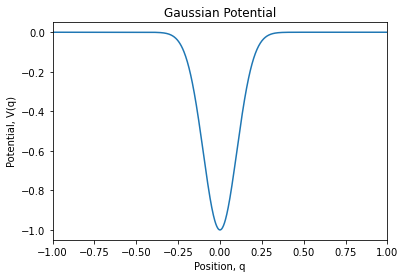

In [30]:
### Might change to regular potential ###

#def gaussian_potential(A, sigma):
#    return (A*np.exp(sigma*q**2))

def gaussian_potential(v_0, sigma):
    return -v_0*np.exp(-q**2/(2*sigma**2))

v_0 = 1
#A = 8000 * 10**(8) # Angstrom(-1)
sigma = 0.1 # Angstrom

q = np.linspace(-1, 1, 1000)
plt.plot(q, gaussian_potential(v_0, sigma))
plt.title("Gaussian Potential")
plt.xlim(-1, 1)
plt.xlabel("Position, q")
plt.ylabel("Potential, V(q)")
plt.savefig("gaussian_vVq.png")
plt.show()

New potential given by: https://demonstrations.wolfram.com/EnergiesForParticleInAGaussianPotentialWell/

### 2. Derivation of  QHD formulas

**2.1 The q expression**

q = dt*p/mass + q

q2 = dt*(2.0*q*p/mass + 1/mass) + q**2


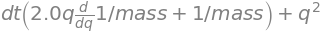

In [31]:
q, p, mass, dt = symbols("q p mass dt")

print("q = " + str(QHD_int(q, 1, dt)) + "\n")

print("q2 = " + str(QHD_int(q, 2, dt)).replace("Derivative(1, q)", "p"))

QHD_int(q, 2, dt)

**2.2 Taking the derivative in Python**

We can do a change of variable in the potential to:

$$x=e^{-\sigma q**2}$$

And so:

$$V(q)=A*x$$

We will now take the first and second derivatives of the original potential, and then perform the change of variables:

In [43]:
sigma, q, A = symbols("sigma, q, A")

gaussian_potential = -v_0*exp(-q**2/(2*sigma**2))

x = exp(-q**2/(2*sigma**2))

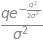

In [44]:
sigma, q, A = symbols("sigma, q, A")

diff1 = diff(gaussian_potential, q)

diff1

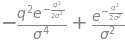

In [45]:
sigma, q, A = symbols("sigma, q, A")

diff2 = diff(diff1, q)

diff2

In [46]:
x = Symbol("x")

diff11 = diff1.replace(exp(-q**2/(2*sigma**2)), x)

diff11

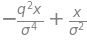

In [47]:
diff22 = diff2.replace(exp(-q**2/(2*sigma**2)), x)

diff22

**2.3 The p expressions:**

In [48]:
p,x,x2,dt,mass,alpha,D = symbols("p,x,x2,dt,mass,alpha,D")

QHD_p = sympify(str(QHD_int(p, 1, dt)).replace("Derivative(v(q), q)", str(diff11)))

print("p = " + str(QHD_p) + "\n")

QHD_p2 = sympify(str(QHD_int(p, 2, dt)).replace("Derivative(v(q), (q, 2))", str(diff22)).replace("Derivative(v(q), q)", str(diff11)))

print("p2 = " + str(QHD_p2) + "\n")

p = -dt*q*x/sigma**2 + p

p2 = dt*(4.0*p*q*x/sigma**2 - 2.0*q**2*x/sigma**4 + x/sigma**2) + p**2



**2.4 Generalizability**

In [49]:
q, p, x, x2, xp, dt, mass, alpha, D = symbols("q, p, x, x2, xp, dt, mass, alpha, D")

q1 = QHD_int(q, 1, dt)

#print(q1)

x = exp(-q**2/(2*sigma**2))

x1 = sympify(str(QHD_int(x, 1, dt)).replace("Derivative(1, (q, 2))", "p**2").replace("Derivative(1, q)", "p"))

print(x1)

x21 = QHD_int(x, 2, dt)

#print(x21)

xp1 = QHD_int(xp, 1, dt)

#print(xp1)

p1 = sympify(str(QHD_int(p, 1, dt)).replace("Derivative(v(q), q)", str(diff11)))

#print(p1)

p21 = sympify(str(QHD_int(p, 2, dt)).replace("Derivative(v(q), (q, 2))", str(diff22)).replace("Derivative(v(q), q)", str(diff11)))

#print(p21)

dt*(-p*q*exp(-q**2/(2*sigma**2))/(mass*sigma**2) + 0.5*q**2*exp(-q**2/(2*sigma**2))/(mass*sigma**4) - 0.5*exp(-q**2/(2*sigma**2))/(mass*sigma**2)) + exp(-q**2/(2*sigma**2))


### 3. Plot position versus time

In [52]:
### Time how long it takes to compute ###

import time 
begin = time.time()

### Parameters: ###

q0 = 0.15
p0 = 0.0
s0 = 0.05
ps0 = 0.0


v_0 = 1
mass = 1836
#A = 8000 * 10**(8)
sigma = 0.1 
hbar = 0.6582  # eV * fs

q_list = []
y_list = []
y_list1 = []
y_list2 = []

Etot = 0.0
Etot0 = 0.0
Etot_cl = 0.0
Etot_cl0 = 0.0
q,p,pq,q2,p2,x,x2,xp,xq = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
q, p = q0, p0
q2 = q*q + s0*s0
pq = ps0*s0 + q*p
p2 = p*p + ps0*ps0 + (0.5*hbar/s0)**2
x = exp(-q**2/(2*sigma**2)) #exp(sigma*q**2) #exp(-alpha*q0)*exp(0.5*alpha*alpha*s0*s0)
#x2 = exp(-2.0*alpha*q0)*exp(2.0*alpha*alpha*s0*s0)
#xq = #x*(q-alpha*s0*s0)
#xp = x*(p - s0*ps0*alpha)

Etot, Etot_cl = Etot0, Etot_cl0

dt = 0.0
p = QHD_int(p, 1, dt)
p2 = QHD_int(p, 2, dt)
Ekin_cl = 0.5*p*p/mass
Ekin    = 0.5*p2/mass
Epot_cl = D*(exp(-2.0*alpha*q) - 2.0*exp(-alpha*q))
Epot    = D*(x2 - 2.0*x)
Etot_cl = Ekin_cl + Epot_cl
Etot    = Ekin    + Epot

Etot, Etot_cl = Etot0,Etot_cl0


### Compute the y values ###

dt = 0.1
t = 0.0
T = 5000

y_list = []

while t <= T:
    x = eval(str(x1))
   
    q = eval(str(q1))  
    
    p = eval(str(p1))
    
    p2 = eval(str(p21))
    
    Ekin_cl = 0.5*p**2/mass
    Ekin    = 0.5*p2/mass
    Epot_cl = D*(exp(-2.0*alpha*q) - 2.0*exp(-alpha*q))
    Epot    = D*(x2 - 2.0*x)
    Etot_cl = Ekin_cl + Epot_cl
    Etot    = Ekin    + Epot

    Etot0 = Etot
    
    Etot1 = Etot/Etot0
    
    y_list.append(Etot1)
    y_list1.append(Etot)
    y_list2.append(Etot_cl)
    
    q_list.append(q)
    
    t = t + dt
    
    
time.sleep(1)
# store end time
end = time.time()
  
# total time taken
print(f"Total runtime is {end - begin}")

Total runtime is 389.76370453834534


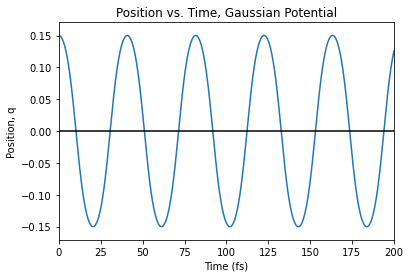

In [60]:
### Define the x values ###

x_list = np.arange(0, 5000, 0.1)
plt.plot(x_list, q_list)
plt.plot([0, 1000], [0, 0], "k-")
plt.title("Position vs. Time, Gaussian Potential")
plt.xlim(0, 200)
plt.xlabel("Time (fs)")
#plt.ylim(-0.5, 0.5)
plt.ylabel("Position, q")
plt.savefig('gaussian_qVt.png')
plt.show()

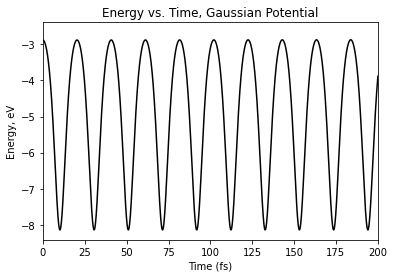

In [57]:
### Define the x values ###

x_list = np.arange(0, 5000, 0.1)
#plt.plot(x_list, y_list)
plt.plot(x_list, y_list1, "k")
#plt.plot(x_list, y_list2, "m")
#plt.legend(["E/E_0", "E", "E_0"])
#plt.plot([0, 500], [0, 0], "k-")
plt.title("Energy vs. Time, Gaussian Potential")
plt.xlim(0, 200)
plt.xlabel("Time (fs)")
#plt.ylim(-0.5, 0.5)
plt.ylabel("Energy, eV")
plt.savefig('gaussian_eVt.png')
plt.show()

In [ ]:
sigma, q = symbols("sigma, q")

x = exp(sigma*q**2)

x

In [ ]:
print(QHD_int(x, 1, dt))

In [ ]:
QHD_int(q, 2, dt)